# Binary classification for recognizing Julia Roberts

In this notebook I use transfer learning to learn how to tell apart Julia Roberts from other celebrities. I use the Mobilenet_v2 model 
with the pretrained weights provided by PyTorch. Below I extract a test set and a training set with the appropriate labels for binary classification, i.e. an image of Julia Roberts is 1 and an image that is not of Julia Roberts is 0. Use *!pip install torchvision*

In [1]:




import os
import shutil
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from torchvision import models
from torch import nn, optim
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import MobileNet_V2_Weights


# Paths
src_dirs = {
    "roberts_images/mobilenet_ready": "training_data/roberts",
    "not_roberts_images/mobilenet_ready": "training_data/notroberts"
}

# Step 1: Clean and recreate training_data/
shutil.rmtree("training_data", ignore_errors=True)
for dst in src_dirs.values():
    os.makedirs(dst, exist_ok=True)

# Step 2: Copy images into class folders (cage = class 0, notcage = class 1)
for src, dst in src_dirs.items():
    for fname in os.listdir(src):
        src_path = os.path.join(src, fname)
        dst_path = os.path.join(dst, fname)
        if os.path.isfile(src_path):
            shutil.copy2(src_path, dst_path)

# Step 3: Define MobileNet-compatible transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Step 4: Load dataset and split
dataset = datasets.ImageFolder("training_data", transform=transform)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],
                                           generator=torch.Generator().manual_seed(42))

# Step 5: Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Step 6: Device selection
device = torch.device("cpu")


# ✅ Confirm
print(f"Classes: {dataset.classes} (mapped as {dataset.class_to_idx})")
print(f"Train set: {len(train_dataset)} images")
print(f"Test set: {len(test_dataset)} images")


Classes: ['notroberts', 'roberts'] (mapped as {'notroberts': 0, 'roberts': 1})
Train set: 1609 images
Test set: 179 images


In [2]:

# Get class-to-index mapping from the dataset
print("Class to index mapping:", dataset.class_to_idx)

# Count samples per class in training set
from collections import Counter
label_counts = Counter([dataset[i][1] for i in train_dataset.indices])

# Print counts
for class_name, class_idx in dataset.class_to_idx.items():
    print(f"{class_name} (label {class_idx}): {label_counts[class_idx]} training samples")

# Sanity check: show a few sample labels from the train set
for i in range(3):
    img, label = train_dataset[i]
    print(f"Sample {i}: Label {label} ({list(dataset.class_to_idx.keys())[label]})")


Class to index mapping: {'notroberts': 0, 'roberts': 1}
notroberts (label 0): 800 training samples
roberts (label 1): 809 training samples
Sample 0: Label 0 (notroberts)
Sample 1: Label 0 (notroberts)
Sample 2: Label 1 (roberts)


# Summary of model

Below is a summary of the model. As you can see, there are 19 blocks of which 17 are of the type "InvertedResidual", which lead to an increase of channels and a decreate of the spatial dimensionality, so that as one goes deeper into the CNN it learns to pick up on more subtle features. 

In [3]:
from torchsummary import summary
from torchvision import models

model = models.mobilenet_v2(weights="DEFAULT")
summary(model, input_size=(3, 224, 224), device="cpu")  # or "cuda" if you're using GPU

blocks = list(model.features.children())

# Track parameter tensors and which block they belong to
block_infos = []
param_index = 0
all_params = list(model.features.parameters())

for i, block in enumerate(blocks):
    block_params = list(block.parameters())
    n_params = len(block_params)
    start_idx = param_index
    end_idx = param_index + n_params - 1 if n_params > 0 else "–"
    block_infos.append({
        "Block": i,
        "Type": block.__class__.__name__,
        "Param indices": f"{start_idx}–{end_idx}" if isinstance(end_idx, int) else "None"
    })
    param_index += n_params

# Print table
print(f"{'Block':<6} {'Type':<25} {'Layer indices':<15}")
print("-" * 50)
for info in block_infos:
    print(f"{info['Block']:<6} {info['Type']:<25} {info['Param indices']:<15}")

print(f"\n🔢 Total number of feature blocks: {len(blocks)}")
print(f"🧠 Total number of parameter tensors in features: {len(all_params)}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

# Training the model

Below I train the final layers of the model. I try three types of transfer, that is I unfreeze either the last 2,3 or 4 blocks of the model 
so they are trained to recognize Julia Roberts. The more layers you freeze, the more risk of overfitting, so one needs to check how well the model does 
on the test set. It turns out that unfreezing only two blocks gives the best test set accuracy. 


🔁 Transfer Learning with last 4 blocks unfrozen
Epoch 1/8 - Loss: 0.4916

📊 Classification Report after Epoch 1:
                   precision    recall  f1-score   support

Not Nicholas Cage       0.86      0.79      0.82        92
    Nicholas Cage       0.80      0.86      0.83        87

         accuracy                           0.83       179
        macro avg       0.83      0.83      0.83       179
     weighted avg       0.83      0.83      0.83       179

Epoch 2/8 - Loss: 0.2872

📊 Classification Report after Epoch 2:
                   precision    recall  f1-score   support

Not Nicholas Cage       0.93      0.87      0.90        92
    Nicholas Cage       0.87      0.93      0.90        87

         accuracy                           0.90       179
        macro avg       0.90      0.90      0.90       179
     weighted avg       0.90      0.90      0.90       179

Epoch 3/8 - Loss: 0.1752

📊 Classification Report after Epoch 3:
                   precision    recall  f1

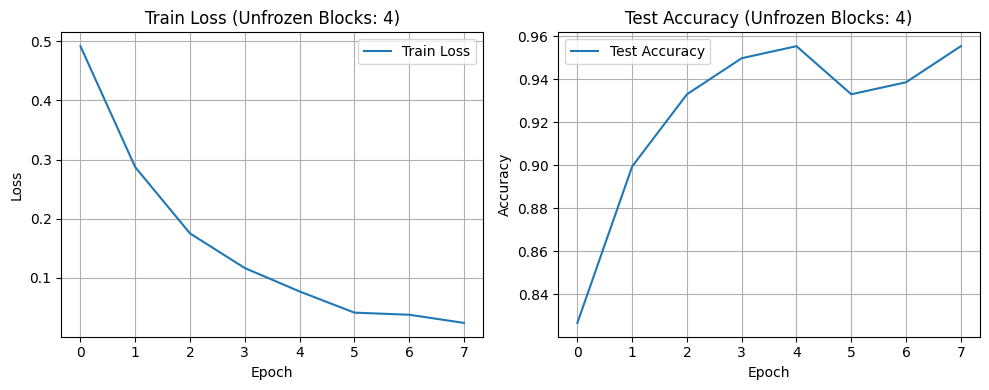


🔁 Transfer Learning with last 3 blocks unfrozen
Epoch 1/8 - Loss: 0.5182

📊 Classification Report after Epoch 1:
                   precision    recall  f1-score   support

Not Nicholas Cage       0.82      0.82      0.82        92
    Nicholas Cage       0.81      0.82      0.81        87

         accuracy                           0.82       179
        macro avg       0.82      0.82      0.82       179
     weighted avg       0.82      0.82      0.82       179

Epoch 2/8 - Loss: 0.3252

📊 Classification Report after Epoch 2:
                   precision    recall  f1-score   support

Not Nicholas Cage       0.89      0.89      0.89        92
    Nicholas Cage       0.89      0.89      0.89        87

         accuracy                           0.89       179
        macro avg       0.89      0.89      0.89       179
     weighted avg       0.89      0.89      0.89       179

Epoch 3/8 - Loss: 0.2316

📊 Classification Report after Epoch 3:
                   precision    recall  f1

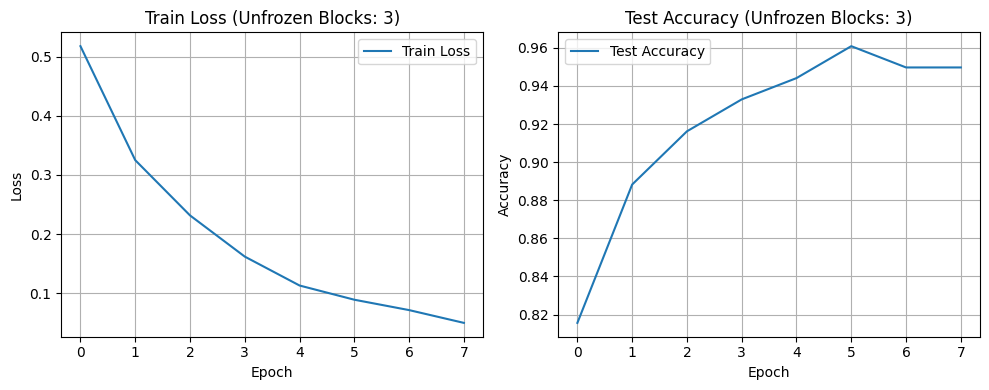


🔁 Transfer Learning with last 2 blocks unfrozen
Epoch 1/8 - Loss: 0.5407

📊 Classification Report after Epoch 1:
                   precision    recall  f1-score   support

Not Nicholas Cage       0.86      0.78      0.82        92
    Nicholas Cage       0.79      0.86      0.82        87

         accuracy                           0.82       179
        macro avg       0.82      0.82      0.82       179
     weighted avg       0.82      0.82      0.82       179

Epoch 2/8 - Loss: 0.3729

📊 Classification Report after Epoch 2:
                   precision    recall  f1-score   support

Not Nicholas Cage       0.89      0.79      0.84        92
    Nicholas Cage       0.80      0.90      0.85        87

         accuracy                           0.84       179
        macro avg       0.85      0.85      0.84       179
     weighted avg       0.85      0.84      0.84       179

Epoch 3/8 - Loss: 0.2952

📊 Classification Report after Epoch 3:
                   precision    recall  f1

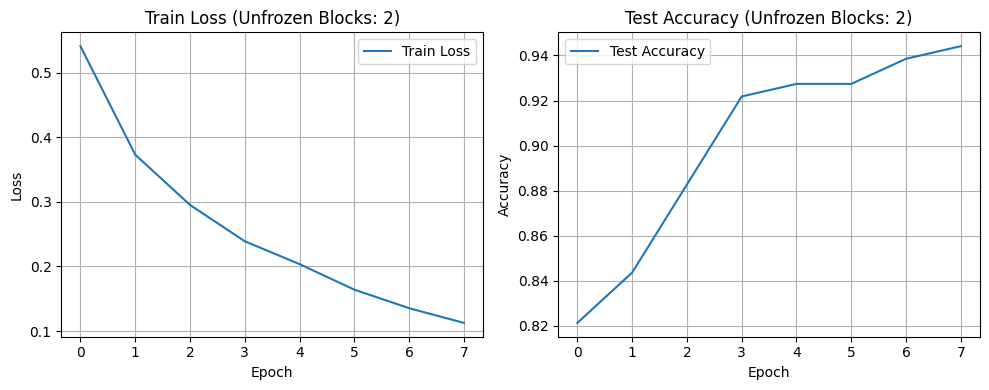

In [4]:
from torchvision import models
from torch import nn, optim
from torchvision.models import MobileNet_V2_Weights
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

transfers = reversed(range(2, 5)) 
epochs = 8

for n in transfers:
    print(f"\n{'='*40}\n🔁 Transfer Learning with last {n} blocks unfrozen\n{'='*40}")

    # Load pretrained MobileNetV2
    weights = MobileNet_V2_Weights.DEFAULT
    model = models.mobilenet_v2(weights=weights)
    model.classifier[1] = nn.Linear(model.last_channel, 1)  # binary classification output

    # Freeze all layers by default
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last `n` blocks of the feature extractor
    last_n_blocks = list(model.features.children())[-n:]
    for block in last_n_blocks:
        for param in block.parameters():
            param.requires_grad = True

    # Keep classifier trainable
    for param in model.classifier.parameters():
        param.requires_grad = True

    model = model.to(device)

    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=(1e-4))

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

        # Evaluation
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                logits = model(images)
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).int().cpu().numpy().flatten()
                y_true.extend(labels.numpy())
                y_pred.extend(preds)

        acc = np.mean(np.array(y_true) == np.array(y_pred))
        test_accuracies.append(acc)
        print(f"\n📊 Classification Report after Epoch {epoch+1}:")
        print(classification_report(y_true, y_pred, target_names=["Not Nicholas Cage", "Nicholas Cage"]))

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Train Loss (Unfrozen Blocks: {n})")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Test Accuracy (Unfrozen Blocks: {n})")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


# Test it on the CelebA set

Now I test it on the CelebA dataset. This dataset is not on this repo but can be downloaded here *https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html* Below I check the model output on the first image.

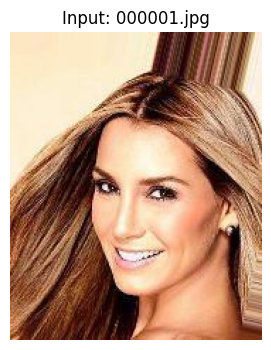

Prediction score: 0.1037 → Binary class: 0


In [5]:
import os
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Set the path to your image folder
image_folder = r"celeba_data\celeba\img_align_celeba"

# List all image files in the folder
image_files = sorted([
    f for f in os.listdir(image_folder)
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
])

# Load the first image
if not image_files:
    raise FileNotFoundError("No images found in the folder.")

image_path = os.path.join(image_folder, image_files[0])
image = Image.open(image_path).convert("RGB")

# Display the image
plt.figure(figsize=(4,4))
plt.imshow(image)
plt.axis('off')
plt.title(f"Input: {image_files[0]}")
plt.show()

# Define transform (resize + normalize for pretrained models)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # adjust if your model uses different norms
])

# Preprocess image
input_tensor = transform(image).unsqueeze(0)  # add batch dimension

# Run inference
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    prediction = torch.sigmoid(output).item()  # use sigmoid if final layer is a single logit

# Convert to binary decision
binary_class = 1 if prediction >= 0.5 else 0

print(f"Prediction score: {prediction:.4f} → Binary class: {binary_class}")


# Find Julia Roberts in the test set

Now I run all the images through the model. As you can see, I take a very high threshold of 0.9995. This is simply because if I don't the 
set of images identified as belonging to Julia Roberts is still huge. The reason why this happens is because the training set used for training
the model is very tiny compared to CelebA so many images are such that based on the model's experience it has a hard time seeing something that resembles either the set of images that are of Julia Roberts or the set of images that aren't.

In [8]:
import os
from PIL import Image
import torch
from torchvision import transforms

# Define the image folder path
image_folder = r"celeba_data\celeba\img_align_celeba"

# List all image files
image_files = sorted([
    f for f in os.listdir(image_folder)
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
])

# Check if folder is empty
if not image_files:
    raise FileNotFoundError("No images found in the folder.")

# Define transform (resize + normalize for MobileNetV2)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Set threshold
threshold = 0.995
passed_images = []

# Set model to evaluation mode
model.eval()

# Device assignment (if not explicitly set elsewhere)
device = next(model.parameters()).device

# Loop through images with progress counter
with torch.no_grad():
    for i, filename in enumerate(image_files, 1):  # start counting at 1
        image_path = os.path.join(image_folder, filename)
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        output = model(input_tensor)
        score = torch.sigmoid(output).item()

        if score >= threshold:
            passed_images.append(filename)

        if i % 10000 == 0:
            print(f"🔄 Processed {i} images... ({len(passed_images)} passed since last report)")

# Output results
print(f"\n✅ {len(passed_images)} out of {len(image_files)} images passed the threshold of {threshold}")
print("Some passing filenames:", passed_images[:10])  # Show first 10


🔄 Processed 10000 images... (3 passed since last report)
🔄 Processed 20000 images... (5 passed since last report)
🔄 Processed 30000 images... (10 passed since last report)
🔄 Processed 40000 images... (14 passed since last report)
🔄 Processed 50000 images... (16 passed since last report)
🔄 Processed 60000 images... (18 passed since last report)
🔄 Processed 70000 images... (22 passed since last report)
🔄 Processed 80000 images... (26 passed since last report)
🔄 Processed 90000 images... (31 passed since last report)
🔄 Processed 100000 images... (34 passed since last report)
🔄 Processed 110000 images... (36 passed since last report)
🔄 Processed 120000 images... (36 passed since last report)
🔄 Processed 130000 images... (38 passed since last report)
🔄 Processed 140000 images... (40 passed since last report)
🔄 Processed 150000 images... (44 passed since last report)
🔄 Processed 160000 images... (48 passed since last report)
🔄 Processed 170000 images... (49 passed since last report)
🔄 Proces

In [9]:
# Save the filenames of passed images to a text file
output_path = "passed_images.txt"

with open(output_path, "w") as f:
    for filename in passed_images:
        f.write(filename + "\n")

print(f"📝 Saved {len(passed_images)} filenames to {output_path}")


📝 Saved 56 filenames to passed_images.txt


In [12]:
import shutil

# Define output folder for passed images
passed_folder = os.path.join(image_folder, "passed_images")
os.makedirs(passed_folder, exist_ok=True)

# Copy passed images to the new folder
for filename in passed_images:
    src_path = os.path.join(image_folder, filename)
    dst_path = os.path.join(passed_folder, filename)
    shutil.copy2(src_path, dst_path)

print(f"📁 Copied {len(passed_images)} images to {passed_folder}")


📁 Copied 56 images to celeba_data\celeba\img_align_celeba\passed_images


# Checking the output of the Julia Roberts picture

So I found only one Julia Roberts image. As you can see the output is a little more than the treshold of 0.995. This means that we can't go much further in raising the threshold without removing all Julia Roberts images. 

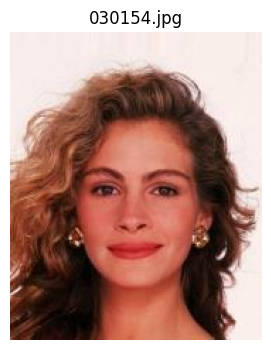

🔍 030154.jpg → Score: 0.996318


In [13]:
import os
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Set the folder where the images are stored
image_folder = r"celeba_data\celeba\img_align_celeba\passed_images"

# Image names to check
filenames_to_check = ["030154.jpg"]

# Define transform (same as used during model evaluation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Set model to evaluation mode
model.eval()
device = next(model.parameters()).device

# Evaluate each image
with torch.no_grad():
    for filename in filenames_to_check:
        image_path = os.path.join(image_folder, filename)
        if not os.path.exists(image_path):
            print(f"❌ Image not found: {filename}")
            continue

        image = Image.open(image_path).convert("RGB")

        # Display image
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{filename}")
        plt.show()

        # Transform and predict
        input_tensor = transform(image).unsqueeze(0).to(device)
        output = model(input_tensor)
        score = torch.sigmoid(output).item()

        print(f"🔍 {filename} → Score: {score:.6f}")


# Checking other Julia Roberts images

The images found is labelled in the identity_CelebA.txt file as 4990. It turns out that 4990 indeed gives only images of Julia Roberts as shown below. Based on what I know now there are probably 22 or perhaps a bit more images of Julia Roberts in the CelebA set. This means our model went from 200K images with 22 Julia Roberts images in it (0.011%) to 56 images with 1 Julia Roberts image in it (7.4%) which is a great improvement. One great way to enhance performance is to now take the CelebA images that were given this very high output from the binary classifier and add them to the not_roberts_images folder and train again, but that is for another time.

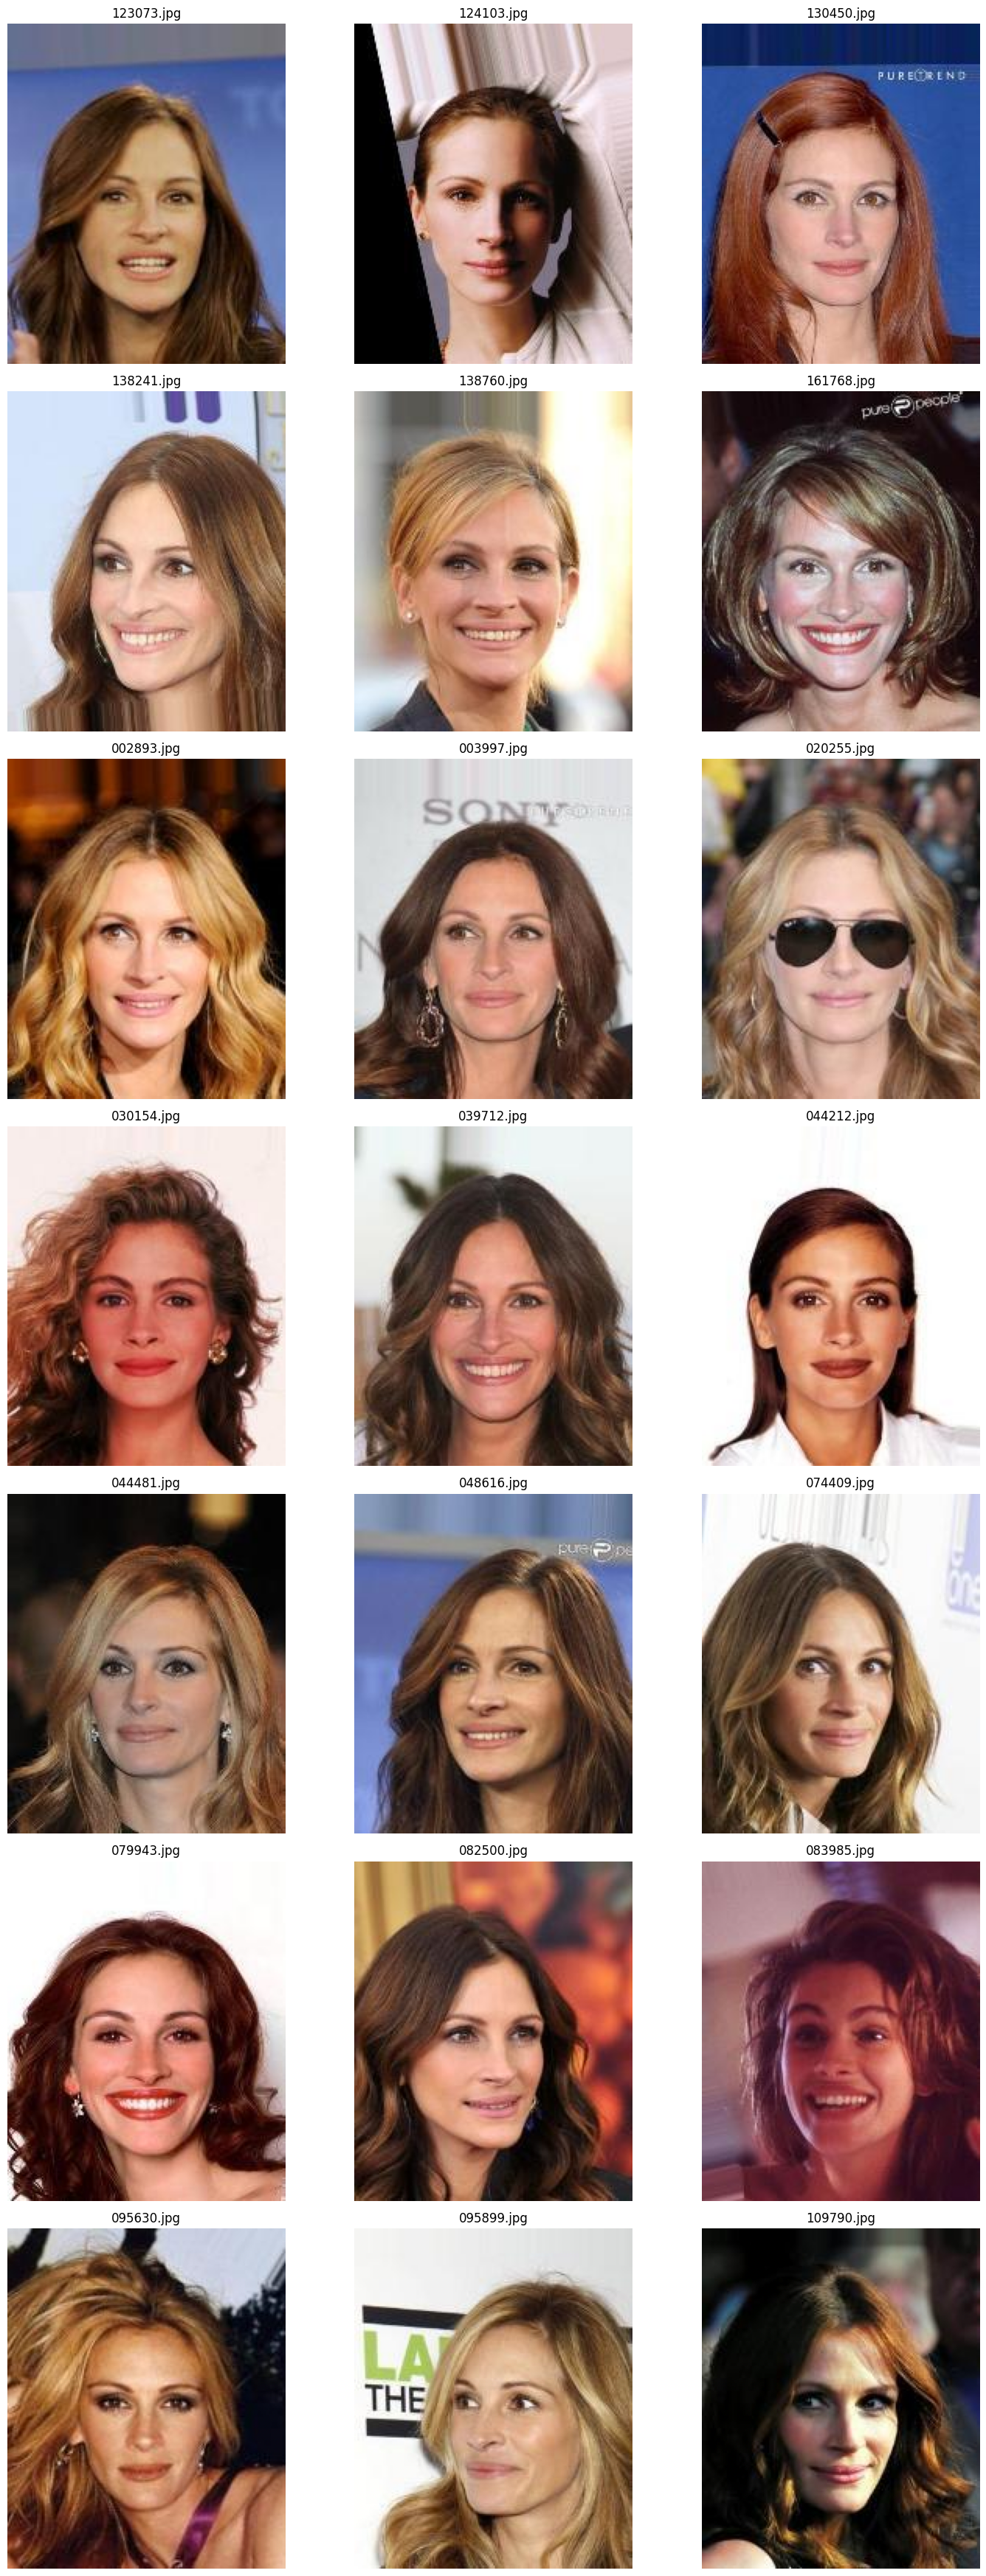

In [14]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# List of image filenames
image_filenames = [
    "123073.jpg", "124103.jpg", "130450.jpg", "138241.jpg", "138760.jpg",
    "161768.jpg", "002893.jpg", "003997.jpg", "020255.jpg", "030154.jpg",
    "039712.jpg", "044212.jpg", "044481.jpg", "048616.jpg", "074409.jpg",
    "079943.jpg", "082500.jpg", "083985.jpg", "095630.jpg", "095899.jpg",
    "109790.jpg"
]

# Path to CelebA image folder (adjust if needed)
image_folder = r"celeba_data\celeba\img_align_celeba"

# Grid configuration
cols = 3
rows = (len(image_filenames) + cols - 1) // cols

# Create figure
plt.figure(figsize=(15, 5 * rows))

for idx, filename in enumerate(image_filenames):
    path = os.path.join(image_folder, filename)
    if not os.path.exists(path):
        print(f"❌ Image not found: {filename}")
        continue

    img = Image.open(path)
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(filename)

plt.tight_layout()
plt.show()


# The images that belong to 4979

In an earlier try where I unfroze three blocks of the mobilnet_v2 I found a Julia Roberts image that was labelled as 4979, but 4979 contains random women not just Julia Roberts as shown below.

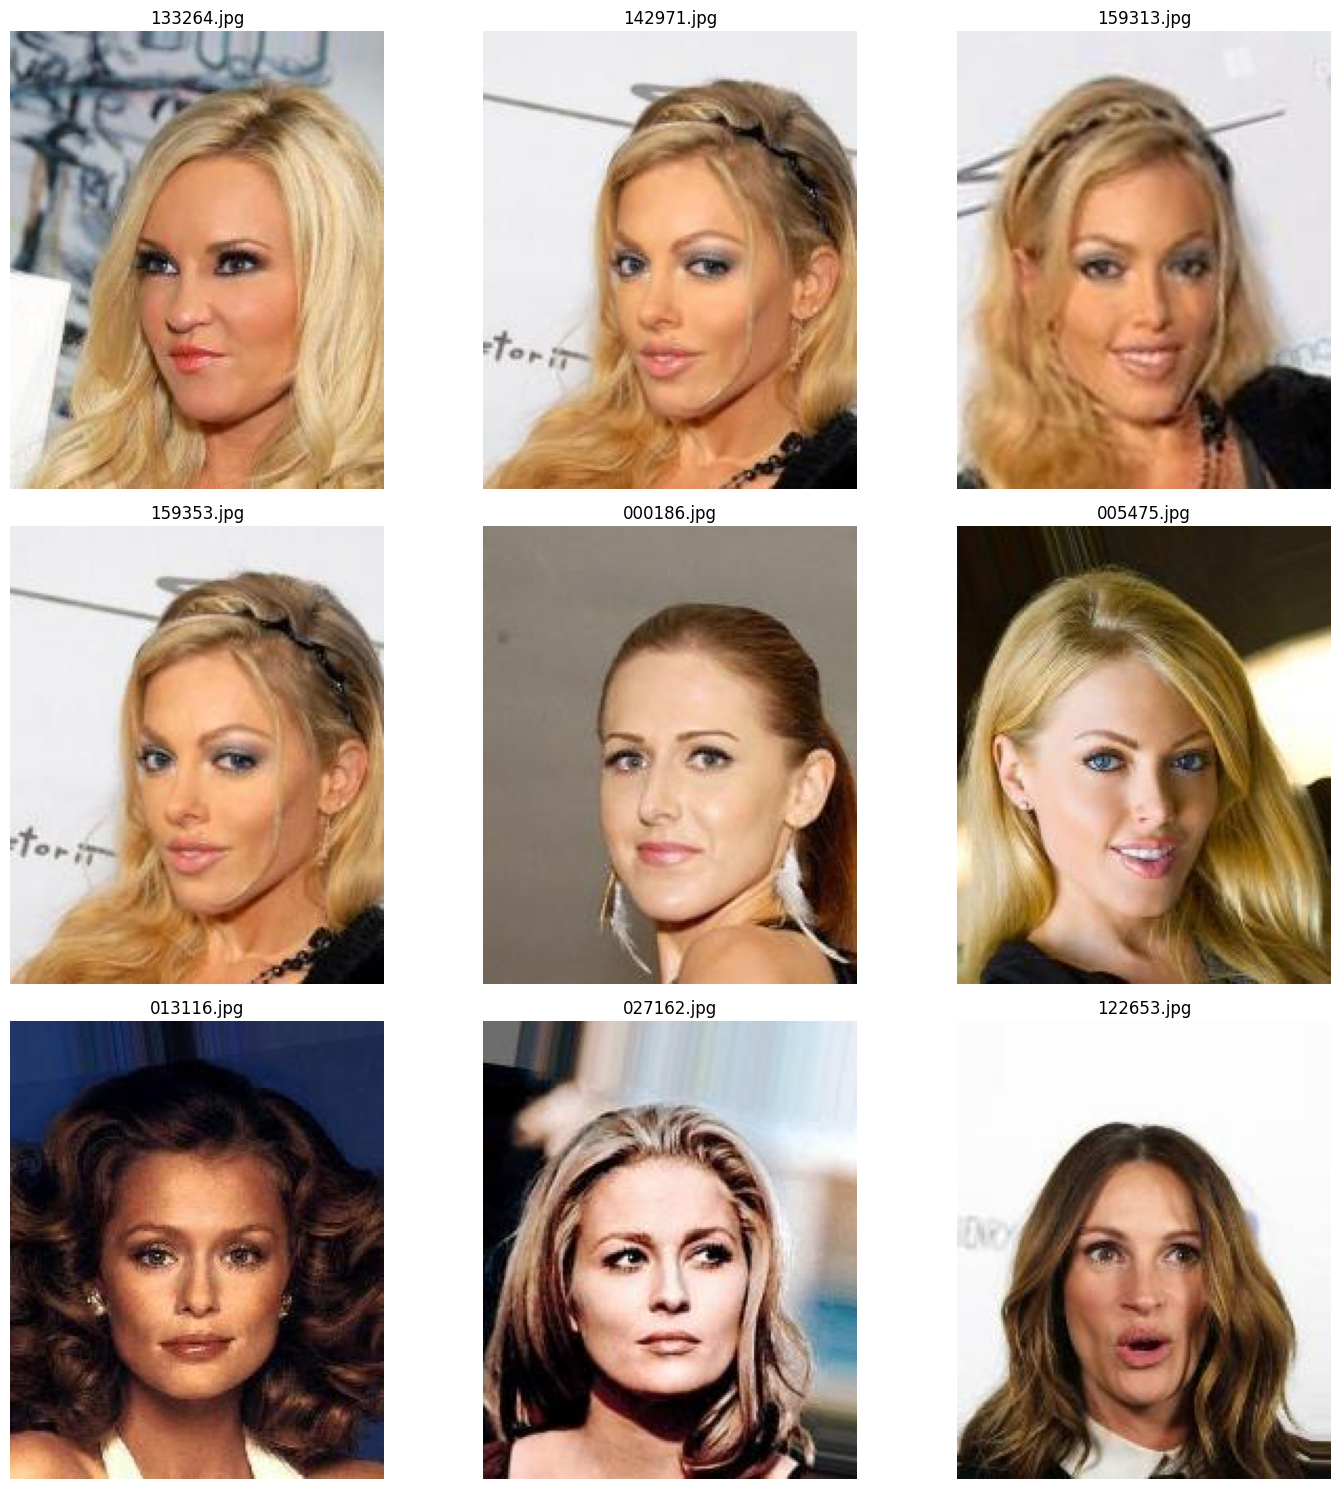

In [17]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# List of image filenames
image_filenames = [
    "133264.jpg", "142971.jpg", "159313.jpg", "159353.jpg", "000186.jpg",
    "005475.jpg", "013116.jpg", "027162.jpg", "122653.jpg"
]

# Path to CelebA image folder (adjust if necessary)
image_folder = r"celeba_data\celeba\img_align_celeba"

# Grid configuration
cols = 3
rows = (len(image_filenames) + cols - 1) // cols

# Create figure
plt.figure(figsize=(15, 5 * rows))

for idx, filename in enumerate(image_filenames):
    path = os.path.join(image_folder, filename)
    if not os.path.exists(path):
        print(f"❌ Image not found: {filename}")
        continue

    img = Image.open(path)
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(filename)

plt.tight_layout()
plt.show()
